# Mnist Classifier From Scratch
---

In [ ]:
import os
import requests
import zipfile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import random
import gzip
import shutil

## 1. Download Mnist Dataset and Unzip
---

In [ ]:
# https://github.com/cvdfoundation/mnist?tab=readme-ov-file
DATA_DIR = "/app/dataset/MNIST"
os.makedirs(DATA_DIR, exist_ok=True)

In [ ]:



def download_mnist():
    MNIST_FILES = {
    "train_images": "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
    "test_images":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz",
    }
    for name, url in MNIST_FILES.items():
        out_path = os.path.join(DATA_DIR, url.split('/')[-1])
        result_path = out_path[:-3] 
        if not os.path.exists(result_path):
            if not os.path.exists(out_path):
                print(f"Downloading {name}...")
                r = requests.get(url)
                with open(out_path, 'wb') as f:
                    f.write(r.content)
            else:
                print(f"{name} already downloaded.")
            print(f"Unzipping {out_path}...")
            with gzip.open(out_path, 'rb') as f_in:
                with open(result_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
        
        else:
            print(f"{name} already unzipped.")

In [66]:
download_mnist()

train_images already unzipped.
train_labels already unzipped.
test_images already unzipped.
test_labels already unzipped.


In [67]:
def loadMNIST( prefix, folder ):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images-idx3-ubyte', dtype = 'ubyte' )
    print(folder + "/" + prefix + '-images-idx3-ubyte')
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    labels = np.fromfile( folder + "/" + prefix + '-labels-idx1-ubyte',
                          dtype = 'ubyte' )[2 * intType.itemsize:]

    return data, labels

trainingImages, trainingLabels = loadMNIST( "train", "/app/dataset/MNIST" )
testImages, testLabels = loadMNIST( "t10k", "/app/dataset/MNIST" )

/app/dataset/MNIST/train-images-idx3-ubyte
/app/dataset/MNIST/t10k-images-idx3-ubyte


## Encode the labels to one hot vectors


To properly represent categorical data, encode the labels which were represented as an array of numbers representing category to one hot vector. In one hot vectors, each category is represented by a vector (array) of N elements, where N is the number of categories.
![One hot vector representation](https://developers.google.com/static/machine-learning/crash-course/images/vocabulary-index-sparse-feature.svg)


In [68]:
def toHotEncoding( classification ):
    # emulates the functionality of tf.keras.utils.to_categorical( y )
    classification = classification.astype(int)  # Ensure integer class labels
    num_samples = classification.shape[0]
    num_classes = np.max(classification) + 1
    hotEncoding = np.zeros((num_samples, num_classes), dtype=np.float32)
    hotEncoding[np.arange(num_samples), classification] = 1
    return hotEncoding

Normalize pixel values of images from 0–255 to a 0–1 range for better neural network training and one-hot encode the training labels

In [ ]:
X_train = trainingImages / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)

X_test = testImages / 255.0
X_test = X_test.reshape(X_test.shape[0], -1)


y_train = toHotEncoding( trainingLabels )
y_test = toHotEncoding( testLabels )

# print out the shape of each
# The training image set has 60000 images with 784 columns(each image is 28x28, flattened, 784)
# The training image labels has 60000 labels with 10 columns(28x28)

print(f"{X_train.shape}:{y_train.shape}")

(60000, 784):(60000, 10)


### Show Sample image from the dataset
Visualize an image from the training set to know what it looks like

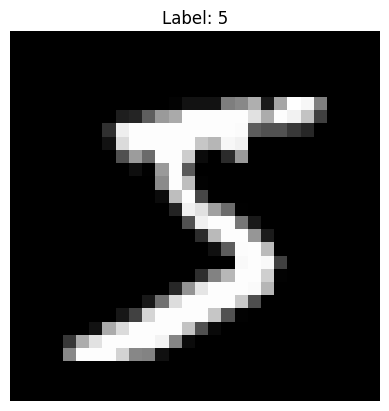

In [70]:
i = 0

image = trainingImages[i]  
label = trainingLabels[i]

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

## 2. Define Activation Functions
---

In [71]:
def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0).astype(np.float64)

def sigmoid(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2



activation_map = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative),
    None: (lambda x: x, lambda x: np.ones_like(x))  # No activation
}

## 3. Define Metrics
---

In [72]:

def binary_cross_entropy(y_pred, y_true, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)

def categorical_cross_entropy(y_pred, y_true,  epsilon=1e-8):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss

def accuracy(y_pred, y_true):
    # Get predicted class indicesa
    pred_labels = np.argmax(y_pred, axis=1)
    
    # Convert one-hot to class indices if needed
    if y_true.ndim == 2:
        true_labels = np.argmax(y_true, axis=1)
    else:
        true_labels = y_true

    correct = np.sum(pred_labels == true_labels)
    total = y_true.shape[0]
    return correct / total

## 4. Define Layer Class

In [73]:

class Layer():

    def __init__(self, inFeature, outFeature, activationFunction=None) -> None:
        # intialize weight with random values with shape(input connection, neuron count)
        self.W = (np.random.randn(inFeature, outFeature) * np.sqrt(2 / (inFeature + outFeature))).astype(np.float64)
        # intialize weight with random values with shape(1, neuron count)
        self.b = np.zeros((1, outFeature), dtype=np.float64)
        # Set layer to be trainable
        self.trainable = True
        # Get activation and its derivative from map(key:value pair)
        self.activation, self.activation_deriv = activation_map.get(activationFunction, (None, None))
        self.y = self.z = self.X = None

    
    #Feed Forward function defined as 
    def Forward(self, X):
        self.X = X
        # Calculate output
        # z = W * X + b, with
        self.z = X @ self.W + self.b
        # Apply Activation Fucntion
        # y = activation(z)
        self.y = self.activation(self.z)
        return self.y


    #Back Propagation fucntion to calculate gradients for this layer as 
    def BackwardHidden(self, dEdy, lr=0.01):
        # Using the derivative of the activation fucntion
        # Find out change of output in respect of to input
        dydx = self.activation_deriv(self.z)
        # Use the derivative chain rule to get dEdx
        dEdx = dEdy * dydx
        # Use the derivative chain rule to get dEdW
        # dEdW = dxdW * dEdx
        # where dxdW is defined as the previous layers output/this layers input, X 
        dEdW = self.X.T @ dEdx
        # dEdb = sum of the total change of error in respect to input
        dEdb = np.sum(dEdx, axis=0, keepdims=True)
        
        # Update Layer Parameter if trainable
        # New Weight = Intial weight - learning rate * change of error in respect to weight
        # New Bias = Intial weight - learning rate * change of error in respect to bias
        if self.trainable:
            self.W -= lr * dEdW
            self.b -= lr * dEdb
        # Propagate gradient
        # calculate the change of error in respect to the previous output
        # dEdy = dEdx * dxdy
        # where dxdy is the change of input in repect to the final output, 
        # as how it contributes to the final output. in other words W
        return dEdx @ self.W.T

## 5. Build Model Class
---

In [74]:

class Model():
    
    # Construct Model with layers
    def __init__(self, layers) -> None:
        self.layers = layers
    
    # Forward Propagation for each layer
    def ForwardProp(self, X):
        for layer in self.layers:
            X = layer.Forward(X)
        return X
    
    # Backward Propagation for each layer
    # Starts at the last layer
    def BackwardProp(self, dEdy, learningRate=0.01):
        for layer in reversed(self.layers):
            dEdy = layer.BackwardHidden(dEdy, lr=learningRate)

    # Train function to train the network
    def train(self, epochs, X_train, y_train, loss_fn, metrics_fn, learningRate=0.01, X_test=None, y_test=None):
        train_loss=[]
        train_metrics=[]
        test_loss=[]
        test_metrics=[]
        for epoch in range(epochs):
            # 1. Get raw output with Forward Propagation
            logits = self.ForwardProp(X_train)
            # 2. Apply softmax to get probabilities, it wont be directly in the output layer 
            # because it simplifies with the categorical cross entropy loss
            probs = softmax(logits)
            # 3. Calculate the loss and metrics
            loss = loss_fn(probs, y_train)
            metrics = metrics_fn(probs, y_train)
            train_loss.append(loss)
            train_metrics.append(metrics)
            # 4. Calculate the change of error in respect to the output of the final layer
            # The derivative of the loss fucntion simplifies to ypred - ytrue
            # and it is finally divided by its batch size
            dEdy = (probs - y_train) / y_train.shape[0]
            # 5. Calculate Gradients and update model parameter with Backward Propagation
            self.BackwardProp(dEdy, learningRate)

            # Do the same procedure with testing data and output logs
            if X_test.shape and y_test.shape is not None:
                test_logits = self.ForwardProp(X_test)
                test_probs = softmax(test_logits)
                test_loss_value = loss_fn(test_probs, y_test)
                test_metrics_value = metrics_fn(test_probs, y_test)
                test_loss.append(test_loss_value)
                test_metrics.append(test_metrics_value)
                print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {metrics:.4f}, Test Loss: {test_loss_value:.4f}, Test Acc: {test_metrics_value:.4f},")
            else:
                print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {metrics:.4f}")
                
        return {"train_loss": train_loss,
             "train_metrics": train_metrics,
             "test_loss": test_loss,
             "test_metrics": test_metrics}



## 6. Build Model
---

Using the Layer and model class together, define a list of layers with set parameters and pass it to the model object

In [75]:
layerSequence = [
    Layer(inFeature=784, outFeature=64,activationFunction="relu"),
    Layer(inFeature=64, outFeature=64, activationFunction="relu"),
    # final layer (softmax applied outside)
    Layer(inFeature=64, outFeature=10,activationFunction=None)  
]
model=Model(layerSequence)

### Test Initial Prediction
From the testing images take one random and test out how the model perform without training

True label: 6, Predicted label: 4


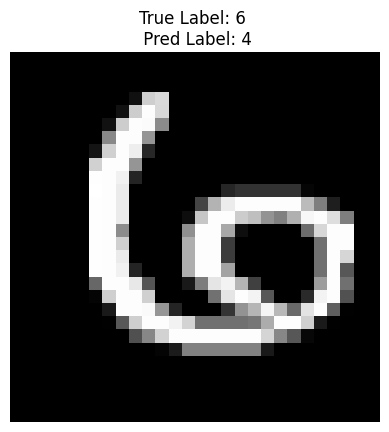

In [76]:
# Display random image
i = random.randint(0,400)
image_raw=testImages[i]
image = testImages[i].reshape(1, -1) / 255.0  
label = testLabels[i]
y_logits = model.ForwardProp(image)
# Apply own softmax
y_pred = softmax(y_logits)


# Take the maximum array value
predicted_class = np.argmax(y_pred)

# Using mathplotlib, display the image
print(f"True label: {label}, Predicted label: {predicted_class}")
plt.imshow(image_raw, cmap='gray')
plt.title(f"True Label: {label} \n Pred Label: {predicted_class}")
plt.axis('off')
plt.show()

## 7. Train Model
---
Using the train function defined in the model class perform full batch training with train and test set

In [ ]:
# Train model
metrics=model.train(epochs=100, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, loss_fn=categorical_cross_entropy, metrics_fn=accuracy, learningRate=0.1)
losses=metrics["train_loss"]

Epoch: 0, Loss: 2.3378, Acc: 0.1081, Test Loss: 2.2844, Test Acc: 0.1356,
Epoch: 1, Loss: 2.2828, Acc: 0.1429, Test Loss: 2.2400, Test Acc: 0.1878,
Epoch: 2, Loss: 2.2388, Acc: 0.1924, Test Loss: 2.1989, Test Acc: 0.2412,
Epoch: 3, Loss: 2.1982, Acc: 0.2438, Test Loss: 2.1586, Test Acc: 0.2923,
Epoch: 4, Loss: 2.1584, Acc: 0.2913, Test Loss: 2.1180, Test Acc: 0.3374,
Epoch: 5, Loss: 2.1184, Acc: 0.3347, Test Loss: 2.0764, Test Acc: 0.3788,
Epoch: 6, Loss: 2.0776, Acc: 0.3744, Test Loss: 2.0337, Test Acc: 0.4192,
Epoch: 7, Loss: 2.0357, Acc: 0.4100, Test Loss: 1.9898, Test Acc: 0.4507,
Epoch: 8, Loss: 1.9928, Acc: 0.4429, Test Loss: 1.9449, Test Acc: 0.4810,
Epoch: 9, Loss: 1.9489, Acc: 0.4722, Test Loss: 1.8988, Test Acc: 0.5081,
Epoch: 10, Loss: 1.9040, Acc: 0.4983, Test Loss: 1.8517, Test Acc: 0.5303,
Epoch: 11, Loss: 1.8580, Acc: 0.5222, Test Loss: 1.8036, Test Acc: 0.5550,
Epoch: 12, Loss: 1.8111, Acc: 0.5448, Test Loss: 1.7547, Test Acc: 0.5766,
Epoch: 13, Loss: 1.7633, Acc: 0.564

To visualize how the loss and accuracy converges, plot both using mathplotlib

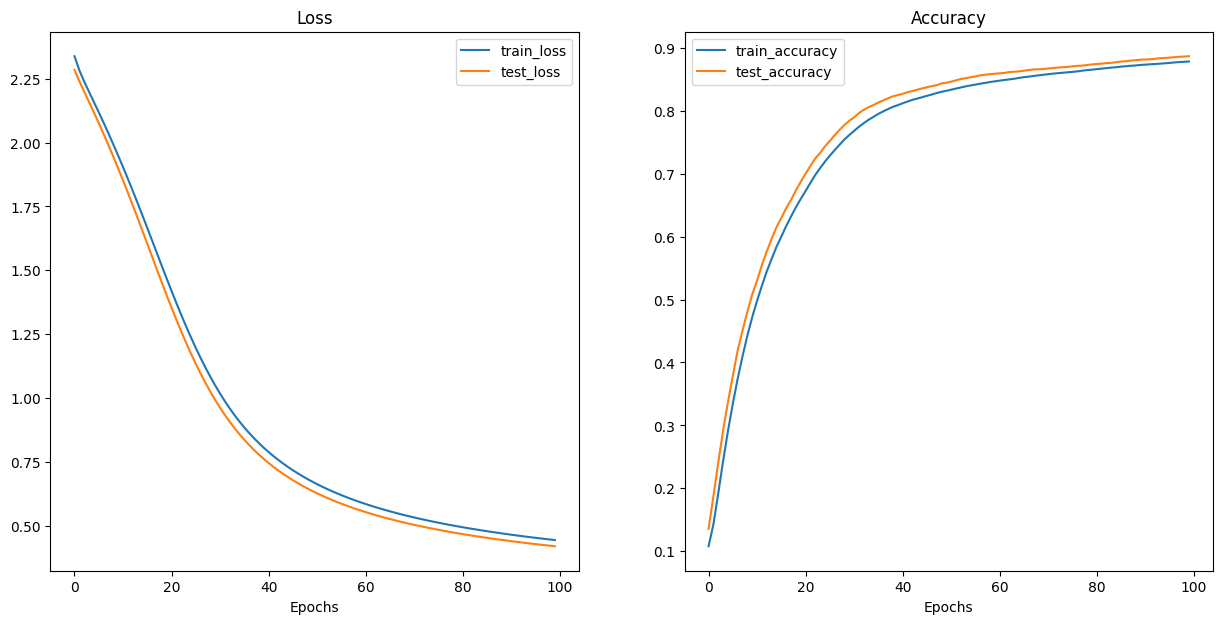

In [78]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_metrics"]
    test_accuracy = results["test_metrics"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(metrics)

### Test Trained Prediction
After training, test out prediction with random images from the test set. The cell below can be run multiple times.

True label: 7, Predicted label: 7


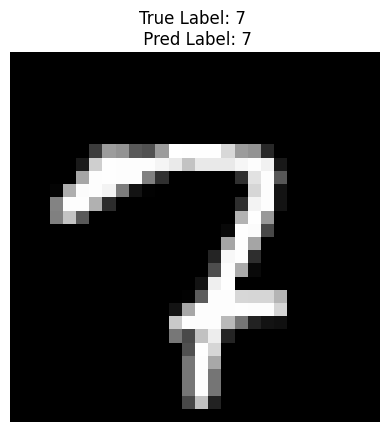

In [79]:
import random
i = random.randint(0,400)
image_raw=testImages[i]
image = testImages[i].reshape(1, -1) / 255.0  
label = testLabels[i]
y_logits = model.ForwardProp(image)
y_pred = softmax(y_logits)



predicted_class = np.argmax(y_pred)

print(f"True label: {label}, Predicted label: {predicted_class}")
plt.imshow(image_raw, cmap='gray')
plt.title(f"True Label: {label} \n Pred Label: {predicted_class}")
plt.axis('off')
plt.show()

## 8. Build Confusion Matrix
---
The next step, to properly evaluate model performance, display the comparison of predicted values and actual values with a confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# source: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

Here in the confusion matrix, it can be clearly seen how much the model missclassifies, and how much it correctly classifies hand drawn digits

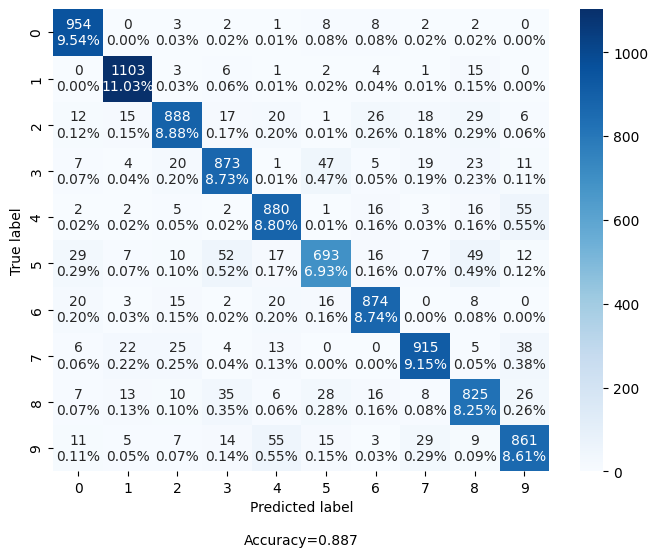

In [81]:
preds = softmax(model.ForwardProp(X_test))
y_true_cls = np.argmax(y_test, axis=1)
y_pred_cls = np.argmax(preds, axis=1)
cf_matrix = confusion_matrix(y_true_cls, y_pred_cls)
make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=True,sum_stats=True)

## Credits
[Github- Mnist Dataser](https://github.com/cvdfoundation/mnist?tab=readme-ov-file)
[Google - One-hot encoding](https://developers.google.com/machine-learning/crash-course/categorical-data/one-hot-encoding)
[Google - Neural Network](https://developers.google.com/machine-learning/glossary#neural_network)